In [ ]:
pip install glob

In [3]:
# Import necessary libraries for data handling and analysis
import pandas as pd
import glob
from afinn import Afinn
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import matplotlib.pyplot as plt

**IMDb**, or the Internet Movie Database, is the world's most popular and authoritative online source for movie, TV, and celebrity content. 
- Superman (2025) movie reviews: https://www.imdb.com/title/tt5950044/reviews/?ref_=tt_ururv_genai_sm

In [4]:
# Load the first 100 positive review text files
pos_review = (glob.glob(r"...\pos\*.txt"))[0:100]

In [5]:
# Read each file and append its content to a list
lines_pos = []
for i in pos_review:
    try:
        f = open(i, 'r')
        temp = f.readlines()[0]
        lines_pos.append(temp)
        f.close()
    except Exception as e:
        continue

In [6]:
lines_pos[:1] # display the first review from 100 positive reviews.

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!']

In [7]:
len(lines_pos) # confirming that 100 reviews have been successfully loaded into the list.

100

In [8]:
# Tokenizer to extract words
tokenizer = RegexpTokenizer('[\w]+')

In [9]:
# Load English stopwords
stop_words = stopwords.words('english')

In [10]:
stop_words[:10] # displays the list of English stopwords for inspection.

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

### Co-occurrence Frequency Calculation

In [11]:
# Dictionary to store co-occurrence counts
count = {}   

# Process each review to count co-occurring words
for line in lines_pos:
    words = line.lower()
    tokens = tokenizer.tokenize(words)
    # Get unique words, remove stopwords and 'br' tag
    stopped_tokens = [i for i in list(set(tokens)) if not i in stop_words+["br"]]
    # Filter out single-character tokens
    stopped_tokens2 = [i for i in stopped_tokens if len(i)>1]
    
    # Iterate through pairs of words to count co-occurrences
    for i, a in enumerate(stopped_tokens2): # iterates through the filtered words with their index.
        for b in stopped_tokens2[i+1:]: # iterates through the words that appear after word a in the list. This ensures each pair is counted only once.
            if a > b: # ensure that the word pair is always stored in alphabetical order
                count[b, a] = count.get((b, a), 0) + 1 
                # retrieve the current count for the word pair (or 0 if it doesn't exist) and increments it by one.
            else:
                count[a, b] = count.get((a, b), 0) + 1

In [12]:
stopped_tokens2[0:10]

['episodes',
 'since',
 'direct',
 'anderson',
 'nowhere',
 'getting',
 '10',
 'show',
 'dean',
 'keeps']

In [13]:
# Co-occurrence Dictionary
dict(list(count.items())[:5]) 

{('burn', 'ran'): 1,
 ('burn', 'student'): 1,
 ('burn', 'many'): 1,
 ('burn', 'far'): 1,
 ('burn', 'profession'): 1}

In [14]:
# Convert the dictionary to a Data Frame
df=pd.DataFrame.from_dict(count, orient='index')
df.head(5)

,0
"(burn, ran)",1
"(burn, student)",1
"(burn, many)",1
"(burn, far)",1
"(burn, profession)",1


In [15]:
# Create a list of lists from the Data Frame
list1 = []
for i in range(len(df)):
    list1.append([df.index[i][0], df.index[i][1], df[0][i]])

# Create a new, more readable Data Frame
df2 = pd.DataFrame(list1, columns=["term1", "term2", "freq"])

# Sort the Data Frame by frequency in descending order
df3 = df2.sort_values(by=['freq'], ascending=False)

# Reset the index of the sorted Data Frame
df3_pos = df3.reset_index(drop=True)

C:\Users\dadab\AppData\Local\Temp\ipykernel_14132\68165365.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list1.append([df.index[i][0], df.index[i][1], df[0][i]])


In [16]:
list1[0:5]

[['burn', 'ran', 1],
 ['burn', 'student', 1],
 ['burn', 'many', 1],
 ['burn', 'far', 1],
 ['burn', 'profession', 1]]

In [17]:
df2.head(5)

,term1,term2,freq
0,burn,ran,1
1,burn,student,1
2,burn,many,1
3,burn,far,1
4,burn,profession,1


In [18]:
df3.head(5)

,term1,term2,freq
17289,movie,one,41
18614,film,story,41
19759,film,movie,35
21958,movie,story,35
50928,one,story,33


In [19]:
df3_pos.head(15)

,term1,term2,freq
0,movie,one,41
1,film,story,41
2,film,movie,35
3,movie,story,35
4,one,story,33
5,good,movie,32
6,film,one,31
7,movie,see,30
8,film,like,27
9,one,see,27


In [20]:
len(df3_pos)

660206

### Network Visualization

In [21]:
# Import libraries for graph creation and visualization
import networkx as nx
import matplotlib.pyplot as plt

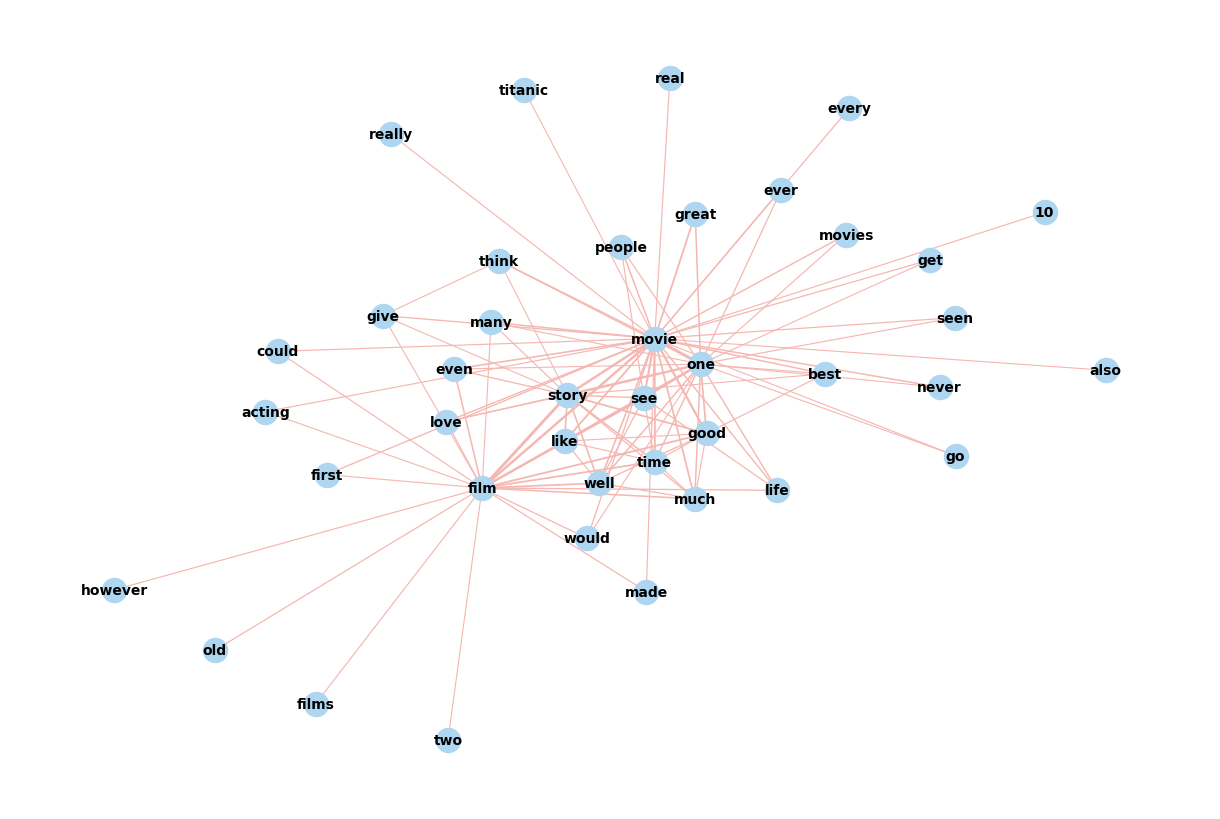

In [22]:
# Initialize an empty graph object. Think of it as a blank canvas.
G_pos = nx.Graph()

# Set a minimum frequency. We only want to see strong connections.
threshold = 15

# Loop through data row by row.
for i in range(len(df3_pos)):
    # Check if the frequency of the current word pair is above our threshold.
    if df3_pos['freq'][i] > threshold:
        G_pos.add_edge(
            df3_pos['term1'][i],      # The first word is the first node.
            df3_pos['term2'][i],      # The second word is the second node.
            weight=int(df3_pos['freq'][i]) # Attach the frequency to the edge as a 'weight'.
        )

# Calculate the positions of the nodes for a visually pleasing layout.
pos = nx.spring_layout(G_pos, seed=42)

# Create a list of line thicknesses based on the stored 'weight' of each edge.
edge_weights = [d['weight'] * 0.05 for (u, v, d) in G_pos.edges(data=True)]

# Set the size of the final image.
plt.figure(figsize=(12, 8))

# 9. Draw the actual graph using the data we've prepared.
nx.draw(
    G_pos,                 # The graph structure to draw.
    pos,                   # The node positions we calculated.
    with_labels=True,      # Show the word on each node.
    node_color="#AED6F1",  # Set the color of the nodes.
    edge_color="#F5B7B1",  # Set the color of the edges.
    font_size=10,
    font_weight="bold",
    width=edge_weights     # Set the thickness of each edge using our list.
)
# 10. Display the final image.
plt.show()

In [23]:
dgr = nx.degree_centrality(G_pos)  
btw = nx.betweenness_centrality(G_pos) 
cls = nx.closeness_centrality(G_pos)  
egv = nx.eigenvector_centrality(G_pos) 

In [24]:
import operator

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)

In [25]:
sorted_dgr[:5]

[('movie', 0.8974358974358974),
 ('one', 0.6153846153846154),
 ('film', 0.5897435897435898),
 ('story', 0.3846153846153846),
 ('good', 0.23076923076923075)]

In [26]:
sorted_btw[:5]

[('movie', 0.5491372662425295),
 ('film', 0.2610131096973202),
 ('one', 0.14866493155966842),
 ('story', 0.023946083156609472),
 ('see', 0.006016644174538911)]

In [27]:
sorted_cls[:5]

[('movie', 0.9069767441860465),
 ('one', 0.7222222222222222),
 ('film', 0.7090909090909091),
 ('story', 0.6190476190476191),
 ('good', 0.5652173913043478)]

In [28]:
sorted_egv[:5]

[('movie', 0.42051835361602735),
 ('one', 0.36521907509705953),
 ('film', 0.33669008271779527),
 ('story', 0.3011118027979603),
 ('good', 0.22759518998475328)]

- **Position**: Determined by the "spring_layout" algorithm to cluster related words.
- **Node (Circle)**: Represents a single word. Its size is determined by its importance (degree centrality).
- **Edge (Line)**: Represents the connection between two words. Its thickness is determined by their relationship strength (co-occurrence frequency).

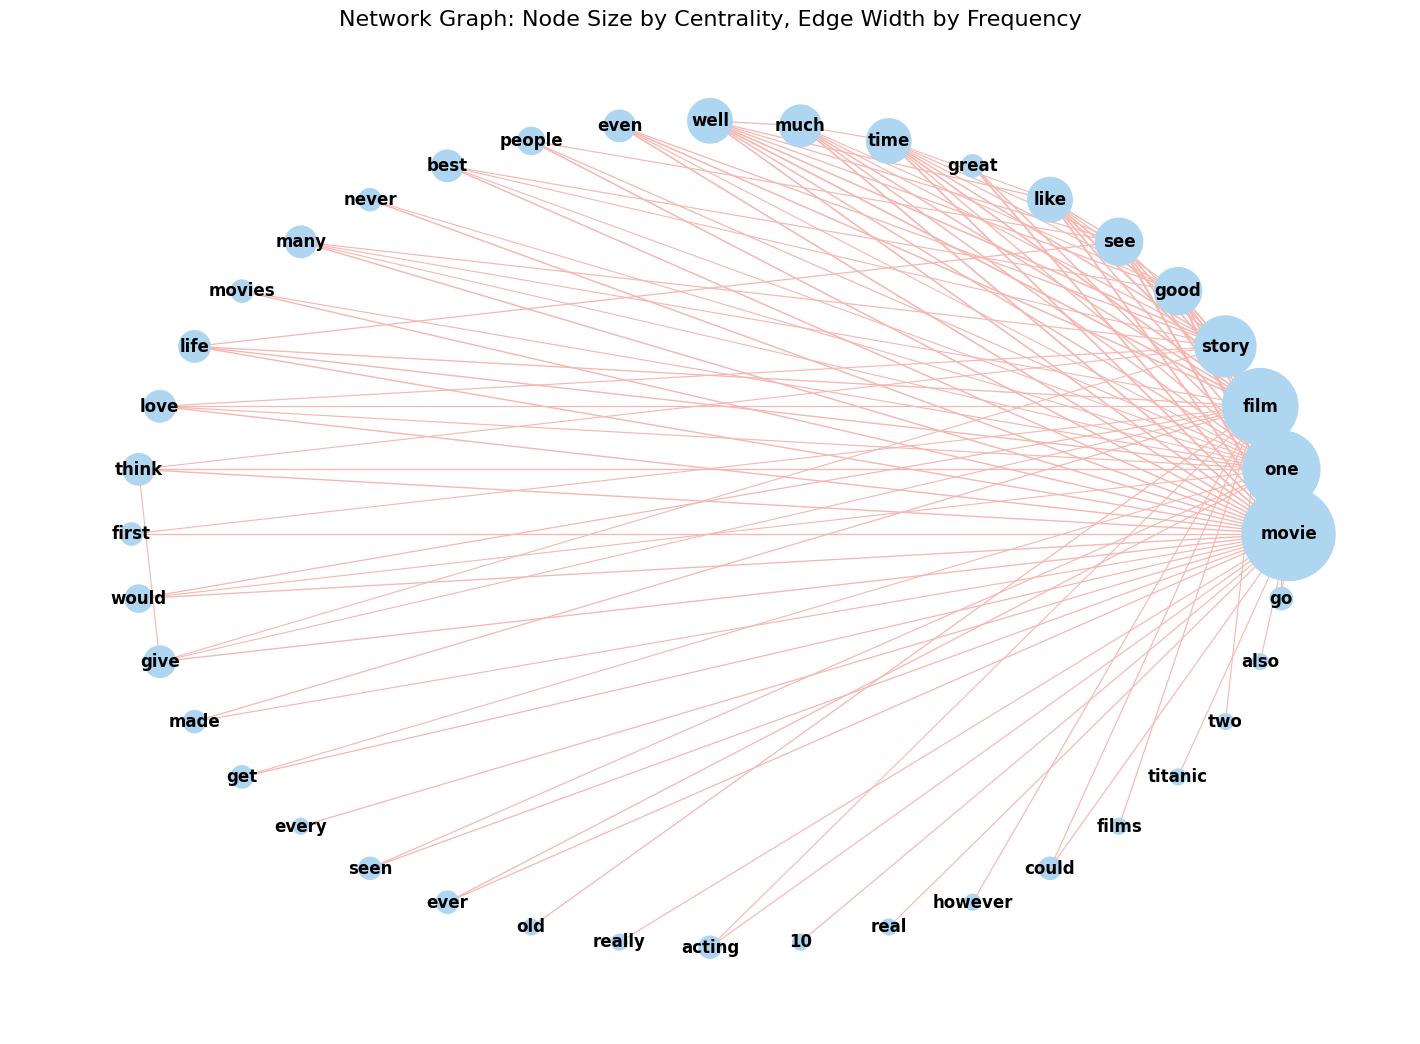

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
 
# Create a list of node sizes based on their centrality.
# We multiply by a large number to make the size difference visible.
node_sizes = [v * 5000 for v in dgr.values()]

# --- Get Edge Weights (Co-occurrence Frequency) ---
# The 'weight' attribute we stored earlier is the frequency.
edge_weights = [d['weight'] * 0.05 for (u, v, d) in G_pos.edges(data=True)]

# --- Visualize the Network ---
# Set the layout for the graph.
pos = nx.circular_layout(G_pos,) # other algorithms circular_layout, shell_layout etc
# k: Controls the optimal distance between nodes.

# Set the figure size.
plt.figure(figsize=(14, 10))

# Draw the graph.
nx.draw(
    G_pos,
    pos,
    with_labels=True,
    
    node_size=node_sizes,      # Node size by degree centrality
    width=edge_weights,        # Edge thickness by frequency
    
    node_color="#AED6F1",
    edge_color="#F5B7B1",
    font_weight="bold",
    font_size=12
)

# Display the plot.
plt.title("Network Graph: Node Size by Centrality, Edge Width by Frequency", fontsize=16)
plt.axis("off")
plt.show()


<span style="font-size:20px"> **networkx** offers several other layout algorithms besides spring_layout. While spring_layout is very common, it is not the only option.

**Here are a few popular alternatives:**

- circular_layout: Arranges nodes in a circle. Useful for seeing all nodes equally.

- kamada_kawai_layout: Another force-directed layout, similar to spring_layout, that can sometimes produce a more spread-out and stable look.

- random_layout: Places nodes randomly. It's fast but usually not very insightful.

- shell_layout: Arranges nodes in concentric circles (shells).